In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import spacy

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import time, math
%matplotlib inline

In [2]:
# !git clone https://github.com/moaaztaha/Image-Captioning

In [3]:
spacy_en = spacy.load('en')
df_path = '../working/Image-Captioning/data.csv'
test_df_path = '../working/Image-Captioning/test.csv'
images_path = '../input/flickr8k/Images/'
test_examples_path = '../working/Image-Captioning/test_examples/'

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.freq_threshold = freq_threshold
        self.itos = {0:"<pad>", 1:"<sos>", 2:"<eos>", 3:"<unk>"}
        self.stoi = {"<pad>":0, "<sos>":1, "<eos>":2, "<unk>":3}
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text.lower())]
    
    def build_vocabulary(self, sentence_list):
        freqs = {}
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize_en(sentence):
                if word not in freqs:
                    freqs[word] = 1
                else:
                    freqs[word] += 1

                if freqs[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize_en(text)
        
        return [self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
               for token in tokenized_text]
                

In [5]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, vocab, transforms=None, freq_threshold=2, split='train'):
        # split has to be one of {train, val, test}
        assert split in {'train', 'val', 'test'}
        
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.vocab = vocab
        self.transforms = transforms
        
        
        # getting image ids and captions based on split
        self.df = self.df[self.df['split'] == split]
        self.img_idx = self.df['file_name'].values
        self.captions = self.df['caption'].values
        
        
        # printing some info
        print(f"Dataset split: {split}")
        print(f"Unique Image: {self.df.file_name.nunique()}")
        print(f"Size: {self.df.shape[0]}")
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.img_idx[index]
        img = Image.open(self.root_dir+img_id).convert("RGB")
        
        if self.transforms is not None:
            img = self.transforms(img)
        else:
            img = transforms.ToTensor()(img)
        
        # numericalize captions
        word_idx = self.vocab.numericalize(caption)
        caption = [self.vocab.stoi["<sos>"]]
        caption.extend(word_idx)
        caption.append(self.vocab.stoi["<eos>"])
        return img, torch.tensor(caption)

In [6]:
def build_vocab(data_file, freq_threshold=2 ,split='train'):
    df = pd.read_csv(data_file)
    df = df[df['split'] == split]
    captions = df.caption.values
    
    vocab = Vocabulary(freq_threshold)
    vocab.build_vocabulary(captions)
    
    return vocab

In [7]:
vocab = build_vocab(df_path)

In [8]:
def plot_sample(ds, idx):
    img = ds[idx][0]
    img = transforms.ToPILImage()(img).convert("RGB")
    plt.imshow(img)
    caption = ' '.join([ds.vocab.itos[i.item()] for i in ds[idx][1]])
    print(caption)

In [9]:
ds = FlickrDataset(images_path, df_path, vocab=vocab, split='train')

Dataset split: train
Unique Image: 6000
Size: 30000


<sos> black dog chasing brown dog through snow <eos>


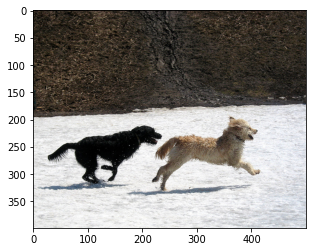

In [10]:
plot_sample(ds, 1)

In [11]:
pad_idx = ds.vocab.stoi['<pad>']

In [12]:
def collate_fn(batch):
    images = [item[0].unsqueeze(0) for item in batch]
    images = torch.cat(images, dim=0)
    
    captions = [item[1] for item in batch]
    captions = pad_sequence(captions, batch_first=False, padding_value=pad_idx)
    
    return images, captions

### Model

In [13]:
class EncoderCNN(nn.Module):
    def __init__(self, hid_dim, dropout, train_cnn=False):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.train_cnn = train_cnn
        
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, hid_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, images):
        features = self.dropout(self.relu(self.inception(images)))
        return features

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim, vocab_size, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        # gru: inputs = [embeddings + context] -> output = [hidden, output]
        self.rnn = nn.GRU(emb_dim+hid_dim, hid_dim)
        # fc: inputs = [embeddings + context + output] -> vocab size
        self.fc_out = nn.Linear(hid_dim*2 + emb_dim, vocab_size)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, context):
        #input = [batch size]
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded =  [1, batch size, emb dim]

        emb_con = torch.cat((embedded, context), dim=2)
        #emb_con = [1, batch size, emb_dim + hid dim]
        
        output, hidden = self.rnn(emb_con, hidden)
        #output = [1, batch size, hid dim] -> seq len and n dirctions = 1
        #hidden = [1, batch size, hid dim] -> n layers and n directions = 1
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim=1)
        #output = [batch size, hid dim]
        
        predictions = self.fc_out(output)
        #predictions = [batch size, vocab size]
        
        return predictions, hidden

In [15]:
class Img2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert self.encoder.hid_dim == self.decoder.hid_dim
        
    def forward(self, src, trg):
        #src = [batch size, 3 , 224, 224]
        #trg = [trg len, batch size]
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.vocab_size
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        context = self.encoder(src).unsqueeze(0)
        hidden = context
        
        input = trg[0, :]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            
            outputs[t] = output
            top1 = output.argmax(1)
            input = top1
            
        return outputs

In [17]:
HID_DIM = 256
EMB_DIM = 256
DROPOUT = .5
VOCAB_LENGTH = len(vocab)
TRAIN_CNN = False
bs = 64
lr = 3e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = EncoderCNN(HID_DIM, DROPOUT)
decoder = DecoderRNN(EMB_DIM, HID_DIM, VOCAB_LENGTH, DROPOUT)

model = Img2Seq(encoder, decoder, device).to(device)

In [18]:
for name, param in model.encoder.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = TRAIN_CNN

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 5,688,429 trainable parameters.


In [20]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [22]:
# transforms 
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_loader = DataLoader(
    dataset=FlickrDataset(images_path, df_path,transforms=transform, vocab=vocab, split='train'),
    batch_size=bs,
    num_workers=2,
    shuffle=True,
    pin_memory=True,
    collate_fn=collate_fn,
    drop_last=True
)

valid_loader = DataLoader(
    dataset=FlickrDataset(images_path, df_path, transforms=transform, vocab=vocab, split='val'),
    batch_size=bs,
    num_workers=2,
    shuffle=True,
    pin_memory=True,
    collate_fn=collate_fn,
    drop_last=True
)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for idx, (imgs, captions) in tqdm(enumerate(iterator), total=len(iterator), leave=False, desc="training"):
        
        optimizer.zero_grad()
        
        imgs = imgs.to(model.device)
        captions = captions.to(model.device)
        
        output = model(imgs, captions)
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        #flattening output and target to ignore <sos>
        output = output[1:].view(-1, output_dim)
        trg = captions[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        loss.backward()
        
        # clip the grads
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        for i, (images, captions) in tqdm(enumerate(iterator), total=len(iterator), leave=False, desc="Evaluating"):
            
            images = images.to(model.device)
            captions = captions.to(model.device)
            
            output = model(images, captions)
            #output = [trg len, batch size, output dim]
            
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = captions[1:].view(-1)
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 3
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'splits.pth')
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')  

In [ ]:
def caption_image(image, model, max_len=50):
    
    model.eval()
    result_caption = []
    
    with torch.no_grad():
        context = model.encoder(image.to(model.device)).unsqueeze(0)
        hidden = context
        input = torch.tensor(vocab.stoi["<sos>"]).unsqueeze(0).to(model.device)
        
        for t in range(1, max_len):
            output, hidden = model.decoder(input, hidden, context)
            top1 = output.argmax(1)
            input = top1
            result_caption.append(top1.item())
            if vocab.itos[top1.item()] == '<eos>':
                break
    return [vocab.itos[idx] for idx in result_caption]

In [ ]:
def print_examples(model, csv_name, root_dir='test_examples'):
    df = pd.read_csv(csv_name)
    imgs = df['image'].tolist()
    captions = df['description'].tolist()
    i = 1
    for img_id, cap in zip(imgs, captions):
        img = Image.open(root_dir+'/'+img_id).convert("RGB")
        plt.imshow(img)
        plt.title(f'Example {i} Correct: {cap}')
        plt.axis('off')
        img = transform(img).unsqueeze(0)
        print(f"Output: {' '.join(caption_image(img, model))}")
        plt.show()
        i+=1

In [ ]:
print_examples(model, csv_name=test_df_path, root_dir=test_examples_path)

### BLEU Score 

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(test_dict, imgs_path, model, max_len=50, n_images=100):
    
    trgs = []
    pred_trgs = []
    
    i = 0
    
    for filename in test_dict:
        if i == n_images:break
        
        # getting the test image
        img = Image.open(imgs_path+'/'+filename).convert("RGB")
        img = transform(img).unsqueeze(0) # making it into a batch
        
        # making prediction
        pred = caption_image(img, model)
        
        if i % 5 == 0:
            print("prediction:", pred[:-1])
            print("actaul 1:", test_dict[filename][0])
        
        pred_trgs.append(pred[:-1])
        trgs.append(test_dict[filename])
        
        i+=1
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
# getting test data
df = pd.read_csv(df_path)
test_df = df[df['split'] == 'test']

img_ids = test_df.file_name.unique()

test_dict = {}
for img_id in img_ids:
    list_tokens = []
    for sent in test_df[test_df['file_name'] == img_id]['caption'].values:
        list_tokens.append(Vocabulary.tokenize_en(sent))
    
    test_dict[img_id] = list_tokens

In [ ]:
calculate_bleu(test_dict, images_path, model, n_images=30)